# Image Segmentation using the idr0021 dataset

This notebook uses the idr0021 dataset ([idr0021-lawo-pericentriolarmaterial/experimentA](http://idr.openmicroscopy.org/webclient/?show=project-51)) and tries to reproduce some of the analysis published in ['Subdiffraction imaging of centrosomes reveals higher-order organizational features of pericentriolar material'](https://doi.org/10.1038/ncb2591); in particular to create a figure similar to [Figure 1](https://www.nature.com/articles/ncb2591/figures/1) of the article.

## Tasks

- Connect to an OMERO.server
- Load data (images, datasets, projects, pixel data)
- Image segmentation using EBImage
- Create ROIs
- Plot the results
- Calculate basic statistics from the segmentation data

## How to use this notebook

The grey blocks with the square brackets to the left are code blocks. Click on a block to select it and click the play button in the toolbar to execute the block of code (alternatively hold SHIFT key and hit ENTER). The bracket will show a star to indicate that this code is currently running. The output is displayed below the block. Wait for it to finish. When the execution is finished the star will be replaced by a number. 

As we go through the notebook you are expected to run the code blocks in order.

Here's an example:

In [1]:
message("Just wait for a bit...")
Sys.sleep(3)
message("Done.")

Just wait for a bit...
Done.


You can change the code and run the block again.

## Let's get started...

Load the necessary libraries:
- [romero-gateway](https://github.com/ome/rOMERO-gateway) for the OMERO <-> R communication
- [EBImage](https://bioconductor.org/packages/release/bioc/html/EBImage.html) to perform the image thresholding.

In [1]:
# Load the libraries
library(romero.gateway)
library(EBImage, warn.conflicts = FALSE)

Loading required package: rJava
Loading required package: jpeg
Loading required package: httr

*** Welcome to rOMERO 0.4.8 ***



## Log in to the OMERO server

In [2]:
server <- OMEROServer(host = 'wss://idr.openmicroscopy.org/omero-ws', port = 443L, username='public', password='public')
server <- connect(server)
paste('Successfully logged in as', server@user$getUserName())

[1] "Successfully logged in as public"

## Load and display an image

In [5]:
imageId <- 1884839 
image <- loadObject(server, "ImageData", imageId)
paste("Image", imageId, "loaded.")

[1] "Image 1884839 loaded."

Load the pixel values and display the image

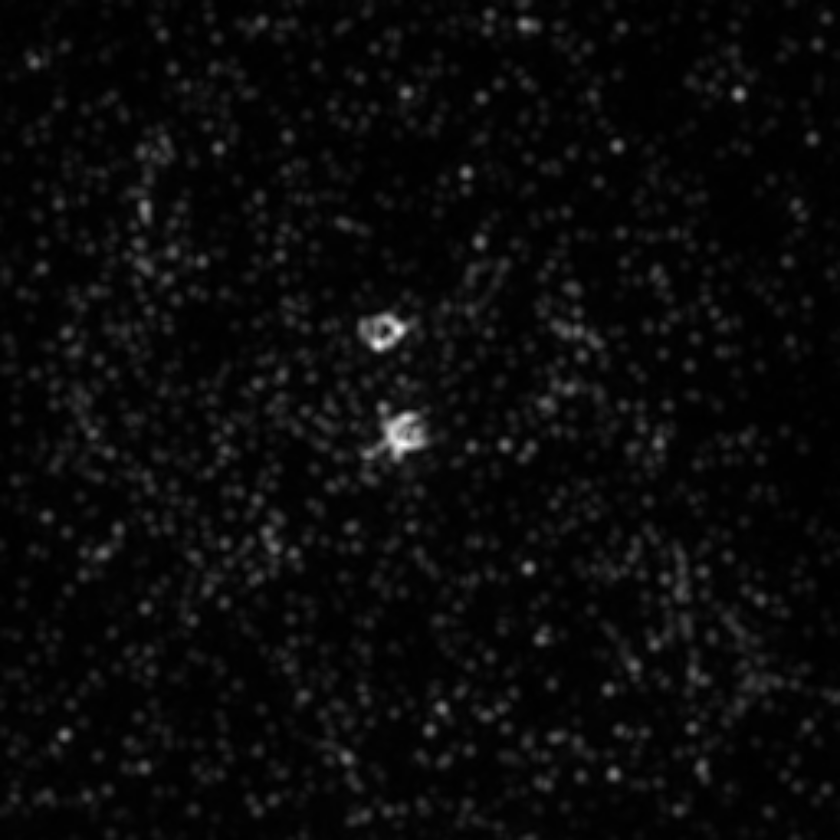

In [5]:
# There is just one plane, so z = 1 and t = 1
z <- 1
t <- 1

# Load the second channel
channelIndex <- 2

pixels <- getPixelValues(image, z, t, channelIndex)

ebimage <- EBImage::Image(data = pixels, colormode = 'Grayscale')
ebimage <- normalize(ebimage)
EBImage::display(ebimage)

## Image segmentation

### Visual

We are using four steps for the segmentation:
- Thresholding using the [thresh](https://www.rdocumentation.org/packages/EBImage/versions/4.14.2/topics/thresh) function to get a binary image.
- Filtering to remove noise, using [medianFilter](https://www.rdocumentation.org/packages/EBImage/versions/4.14.2/topics/medianFilter).
- [fillHull](https://www.rdocumentation.org/packages/EBImage/versions/4.14.2/topics/fillHull) to close holes in the segmented objects.

Note: Up till now we still had a binary image (the pixel array only consists of 0's (background) and 1's (objects)), therefore we need:

- [bwlabel](https://www.rdocumentation.org/packages/EBImage/versions/4.14.2/topics/bwlabel) to distinguish the single objects from each other. It assigns a different number to each object (first object will get pixel values '1', the second pixel values '2', etc.)

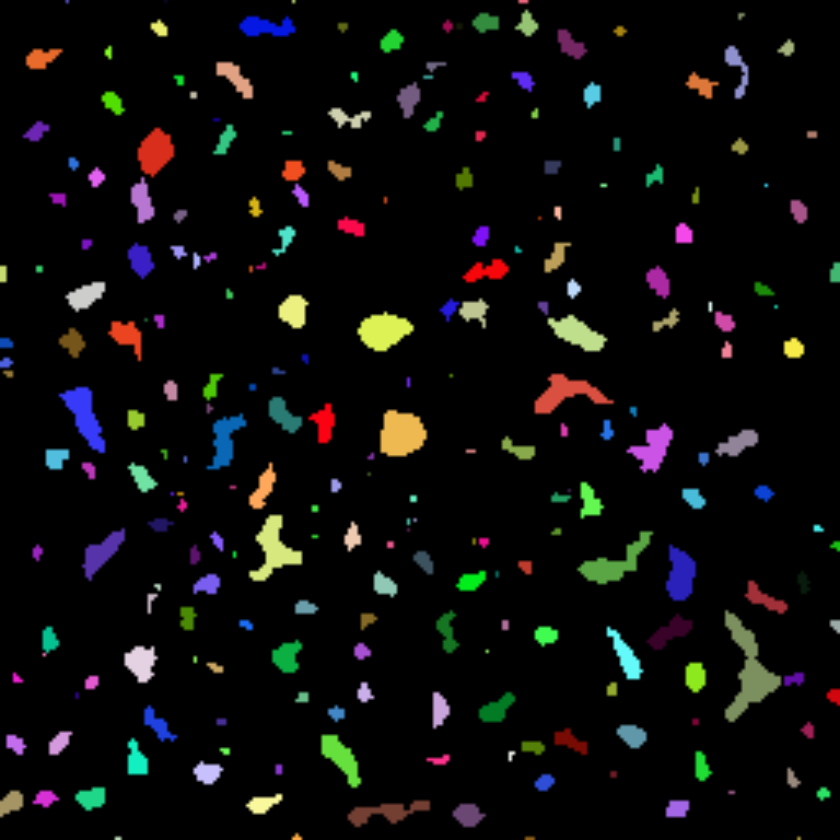

In [6]:
# Threshold
threshImg <- thresh(ebimage, w=10, h=10, offset=0.01)

# Remove noise
threshImg <- medianFilter(threshImg, size=3)

# Fill holes
threshImg <- fillHull(threshImg)          

# Distinguish objects
threshImg <- bwlabel(threshImg)

# Show the segmented image
EBImage::display(colorLabels(threshImg))

**Exercise:** Modify the parameters of the thresh function w, h and offset to get a better segmentation. Goal: The two centrioles should be detected as two separate objects. We don't have to get rid off all the noise, but the two centrioles should be the largest objects detected. (Hint: w=15, h=15, offset=0.1 seems to work pretty well)

### Compute the features (measurements)

Use the [computeFeatures](https://www.rdocumentation.org/packages/EBImage/versions/4.14.2/topics/computeFeatures) methods to calculate some properties of the objects.

In [7]:
shapes = computeFeatures.shape(threshImg)
moments = computeFeatures.moment(threshImg)

# merge the two dataframes together into one 'features' dataframe
features <- merge(shapes, moments, by=0, all=TRUE)
features

Row.names,s.area,s.perimeter,s.radius.mean,s.radius.sd,s.radius.min,s.radius.max,m.cx,m.cy,m.majoraxis,m.eccentricity,m.theta
<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,0.0000000,0.0000000,0.0000000,0.0000000,21.000000,1.000000,0.000000,0.0000000,0.000000e+00
10,8,6,1.2453560,0.1800605,1.1180340,1.5000000,137.000000,8.500000,3.464102,0.5773503,1.570796e+00
100,29,15,2.6006209,0.2335571,2.1868293,2.9522120,242.413793,106.724138,6.278955,0.3757493,5.122576e-01
101,12,10,1.5340525,0.4203366,0.9848858,2.4020824,222.083333,107.416667,5.044025,0.8038460,-1.454864e+00
102,5,5,0.8478015,0.2850134,0.4472136,1.2649111,93.600000,109.800000,3.098387,0.8164966,1.249046e+00
103,9,7,1.3005843,0.2521557,0.9035079,1.7202278,2.333333,111.111111,3.885753,0.6945875,-3.543131e-01
104,6,7,1.0339719,0.4429541,0.4040610,1.7379322,85.166667,113.666667,4.363338,0.9252742,2.257265e-01
105,5,5,0.8478015,0.2850134,0.4472136,1.2649111,3.200000,114.400000,3.098387,0.8164966,3.217506e-01
106,25,18,2.5288553,1.0393265,0.7243558,4.1462463,65.120000,118.320000,9.384197,0.9146676,-1.162370e+00


For further analysis we need the object sizes: 's.area', 's.perimeter', especially 's.radius.mean' (~ diameter).

For the visualisation we can use the location (m.cx, m.mcy), the major radius (m.majoraxis), the minor radius (can be calculated from m.eccentricity) and the rotation angle (m.theta) to draw an Ellipse ROI around each object.

### Create the ROIs from the features table

In order to be able to re-use this code later, we define a function for it:

In [8]:
#' Create ROIs from a features table
#'
#' @param features The shape and moments generated by EBImage computeFeatures
#' @return A dataframe specifying the x, y, rx, ry, w, h, theta and text parameters of the ROIs
createROIs <- function(features) {
    rois <- data.frame(x = c(0), y = c(0), rx = c(0), ry = c(0), w = c(0), h = c(0), theta = c(0), text = c('remove'), stringsAsFactors = FALSE)
    for (index in 1:length(features[,1])) {
        x <- features[index,8]
        y <- features[index,9]
        r1 <- features[index,10]
        ecc <- features[index,11]
        r2 <- sqrt(r1^2 * (1 - ecc^2))
        theta <- features[index,12]
        rois <- rbind(rois, c(x, y, r1, r2, NA, NA, -theta, as.character(index)))
    }
    rois <- rois[-1,]
    rownames(rois) <- c()
    return(rois)
}
print("Function 'createROIs' defined.")

[1] "Function 'createROIs' defined."


In [9]:
rois <- createROIs(features)
rois

x,y,rx,ry,w,h,theta,text
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
21,1,0,0,NA,NA,0,1
137,8.5,3.46410161513775,2.82842712474619,NA,NA,-1.5707963267949,2
242.413793103448,106.724137931034,6.27895460943305,5.81884133707928,NA,NA,-0.51225761447762,3
222.083333333333,107.416666666667,5.04402536508443,3.00037540331586,NA,NA,1.45486399636712,4
93.6,109.8,3.09838667697063,1.78885438200471,NA,NA,-1.24904577239644,5
2.33333333333333,111.111111111111,3.88575337505748,2.79544289069596,NA,NA,0.354313136063922,6
85.1666666666667,113.666666666667,4.36333821343559,1.65500979239979,NA,NA,-0.225726545776959,7
3.2,114.4,3.09838667696579,1.78885438199909,NA,NA,-0.321750554396375,8
65.12,118.32,9.38419708654179,3.79315766096677,NA,NA,1.16236988732183,9


## Automate

Tasks:

- Segment each image of a dataset.
- For visualisation create an ROI for each of the objects detected.
- For further analysis only take the largest object per image into account (assumption: this is a centriole). Parameters to evaluate for this object are area, perimeter and diameter

Note: We need to be able to specify the channel. Only one channel in each image is relevant for our analysis. The relevant channel is identified by its name.

We put all the pieces together and wrap them up in a function called 'analyzeImage':

- Determine the relevant channel
- Load the pixel values
- Perform the segmentation
- Calculate the features of the detected objects
- Create ROIs to visualise the segmentation results (adding the ROI 'index' as text/comment so that we can identify the ROI in the features table)
- Extract the valuable information for further statistical analysis (area, perimeter and diameter of the largest object) 

In [11]:
#' Performs an image segmentation to find the largest ROI of the image
#' and returns some features of interest (area, perimeter and diameter).
#' Optionally: Creates an ROI for each object detected by the segmentation.
#'
#' @param image The image to segment
#' @param channelName The channel to be taken into account
#' @param df The dataframe to add the features to (channelName, imageName, ImageID, ROIIndex, area, perimeter, diameter)
#' @return The dataframe with the features
analyzeImage <- function(image, channelName, df) {
    # Find the channel index
    chnames <- getChannelNames(image)
    chindex <- match(channelName, chnames, nomatch = 0)
    if (chindex == 0) {
      message (paste("Could not resolve channel name, skipping ", image@dataobject$getId()))
      return(df)
    }
    
    # Load the pixels
    pixels <- getPixelValues(image, 1, 1, chindex)
    ebi <- EBImage::Image(data = pixels, colormode = 'Grayscale')
    ebi <- normalize(ebi)
     
    # this is our segmentation workflow from above
    threshImg <- thresh(ebi, w=15, h=15, offset=0.1)
    threshImg <- medianFilter(threshImg, size=3)
    threshImg <- fillHull(threshImg)          
    threshImg <- bwlabel(threshImg)
    
    # Calculate the features
    shapes = suppressMessages(computeFeatures.shape(threshImg))
    moments = suppressMessages(computeFeatures.moment(threshImg))
    features <- merge(shapes, moments, by=0, all=TRUE)
    
    if (length(features[,1])>1) {
        # Add the ROIs to the image
        rois <- createROIs(features)
        
        # Add the interesting properties (area, perimeter and diameter)
        # of the largest object together with channel name, image name, image id 
        # and roi index to the dataframe
        features <- features[order(-features[,2]),]
        diameter <- features[1,4]*2
        df <- rbind(df, c(channelName, image@dataobject$getName(), image@dataobject$getId(), features[1,1], features[1,2], features[1,3], diameter))
    }
    return(df)
}
print("Function 'analyzeImage' defined.")

[1] "Function 'analyzeImage' defined."


Iterate over the dataset and call the analyze function for each of the images:

In [13]:
datasetId <- 51

channelName <- 'CDK5RAP2-C'

dataset <- loadObject(server, "DatasetData", datasetId)

# Keep the channel name, image name, image id, area, perimeter, and diameter of the largest ROIs
result <- data.frame(Channel = c('remove'), ImageName = c('remove'), Image = c(0), ROIIndex = c(0), Area = c(0), Perimeter = c(0), Diameter = c(0), stringsAsFactors = FALSE)

images <- getImages(dataset)
for (image in images) {
    result <- tryCatch({
        analyzeImage(image, channelName, result)
    }, warning = function(war) {
        message(paste("WARNING:  ", image@dataobject$getId(),war))
        return(result)
    }, error = function(err) {
        message(paste("ERROR:  ", image@dataobject$getId() ,err))
        return(result)
    }, finally = {
    })
}

result <- result[-1,]
rownames(result) <- c()

# set the correct datatypes
result$Channel <- as.factor(result$Channel)
result$Area <- as.numeric(result$Area)
result$Perimeter <- as.numeric(result$Perimeter)
result$Diameter <- as.numeric(result$Diameter)

result

ERROR: Error in .jcall("RJavaTools", "Ljava/lang/Object;", "invokeMethod", cl, : omero.gateway.exception.DSOutOfServiceException: Connection lost.


## Statistical analysis

The image segmentation has already been run over the whole idr0021 project and the results attached to the project as table 'Summary from R'. 
We are going to load this table from OMERO as dataframe "centrioles". In this manner, we will quickly obtain a sizeable segmentation dataset to perform a statistical analysis on.

In [ ]:
projectId <- 51 
project <- loadObject(server, "ProjectData", projectId)
dataframes <- availableDataframes(project)
print(dataframes)

In [ ]:
# Load the dataframe
dfID <- dataframes$ID[1]
centrioles <- loadDataframe(project, dfID)

# Make sure the data types are correct
centrioles$Dataset <- as.factor(centrioles$Dataset)
centrioles$Diameter <- as.numeric(centrioles$Diameter)
centrioles

### Plot the data

In [ ]:
# Order the datasets ascending by mean diameter 
ag <-aggregate(centrioles$Diameter ~ centrioles$Dataset, centrioles, median)
ordered <- factor(centrioles$Dataset, levels=ag[order(ag$`centrioles$Diameter`), 'centrioles$Dataset'])

# Draw the plot 
plot(centrioles$Diameter ~ ordered, ylab='Diameter (nm)', xlab="Protein", cex.axis=0.5)

### Interpretation

#### One-way analysis of variance

Is there a significant difference between the proteins?

In [ ]:
fit <- aov(centrioles$Diameter ~ centrioles$Dataset)
summary(fit)

#### Two-sample Wilcoxon test of all pairwise combinations

Are all proteins significantly different from each other?

In [ ]:
# Two-sample Wilcoxon test ('Mann-Whitney') of all pairwise combinations:
combins <- combn(levels(centrioles$Dataset), 2)
params_list <- split(as.vector(combins), rep(1:ncol(combins), each = nrow(combins)))
testResults <- data.frame()
for (param in params_list) {
  testdf <- subset(centrioles, centrioles$Dataset %in% param)
  pval <- wilcox.test(formula = Diameter ~ Dataset, data = testdf)$p.value
  testResults <- rbind(testResults, data.frame(Protein_1=param[1], Protein_2=param[2], p_value=pval))
}
testResults

Finally close the connection to the OMERO.server again:

In [ ]:
disconnect(server)

### License (BSD 2-Clause)

Copyright (c) 2018-2021, University of Dundee All rights reserved.

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.
Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.
THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.